# Resale price with latitude and longitude data

Using knowledge that I found on openmaps API article, I decided to give it a try to see if inputting raw latitude and longitude data can assist in making the model more robust. The csv was prepared for in "write new csv.py" , this was to save the latitude and longitude data so there will not be a need to request for lat and lon data every time.

I also intend to use this knowledge to further improve by adding new features such as distance to mrt, distance to malls, number of nearby malls, distance to town.

## 1. Import packages and getting the data

In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import datetime
%matplotlib inline
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [383]:
# Read csv as dataframe

data = pd.read_csv('model/datawithlatlong.csv', parse_dates=True,index_col=0 )

In [384]:
# get the correct dtypes

data = data.infer_objects()

In [385]:
# check for NA and type
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196957 entries, 0 to 197403
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   month                 196957 non-null  object 
 1   town                  196957 non-null  object 
 2   flat_type             196957 non-null  object 
 3   floor_area_sqm        196957 non-null  float64
 4   flat_model            196957 non-null  object 
 5   resale_price          196957 non-null  float64
 6   Storey                196957 non-null  float64
 7   lease_commence_dt     196957 non-null  object 
 8   remaining_lease_year  196957 non-null  float64
 9   Latitude              196957 non-null  float64
 10  Longitude             196957 non-null  float64
dtypes: float64(6), object(5)
memory usage: 18.0+ MB


In [386]:
#  describe data
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
floor_area_sqm,196957.0,97.285769,24.384450,31.000000,76.000000,95.000000,112.000000,2.800000e+02
resale_price,196957.0,452896.508552,145220.840165,140000.000000,350000.000000,425000.000000,525000.000000,1.295000e+06
Storey,196957.0,8.327538,5.554750,2.000000,5.000000,8.000000,11.000000,5.000000e+01
remaining_lease_year,196957.0,74.531873,12.058751,44.083061,65.085546,73.671622,83.916870,9.783639e+01
Latitude,196957.0,1.366232,0.042789,1.270380,1.336373,1.363939,1.393394,1.457071e+00
Longitude,196957.0,103.839909,0.072476,103.685228,103.775400,103.845206,103.899199,1.039881e+02


In [387]:
data.head(5)

,month,town,flat_type,floor_area_sqm,flat_model,resale_price,Storey,lease_commence_dt,remaining_lease_year,Latitude,Longitude
0,2012-03-01,ANG MO KIO,2 ROOM,45.0,Improved,250000.0,8.0,1986-01-01,72.836561,1.374694,103.836463
1,2012-03-01,ANG MO KIO,2 ROOM,44.0,Improved,265000.0,3.0,1980-01-01,66.835068,1.373401,103.849073
2,2012-03-01,ANG MO KIO,3 ROOM,68.0,New Generation,315000.0,8.0,1980-01-01,66.835068,1.379395,103.839157
3,2012-03-01,ANG MO KIO,3 ROOM,67.0,New Generation,320000.0,3.0,1984-01-01,70.835151,1.362758,103.858015
4,2012-03-01,ANG MO KIO,3 ROOM,67.0,New Generation,321000.0,8.0,1980-01-01,66.835068,1.379867,103.835977


In [397]:
data.groupby("flat_type")[['resale_price','floor_area_sqm']].agg([np.mean,np.median])

resale_price           floor_area_sqm       
                           mean    median           mean median
flat_type                                                      
1 ROOM            206845.764706  208500.0      31.000000   31.0
2 ROOM            246952.981732  245000.0      45.817315   46.0
3 ROOM            328056.845945  318000.0      68.207909   67.0
4 ROOM            448900.628387  423000.0      95.586363   93.0
5 ROOM            541482.437272  505000.0     118.165137  119.0
EXECUTIVE         637686.520188  620000.0     144.206434  145.0
MULTI-GENERATION  788980.000000  779000.0     160.256410  164.0

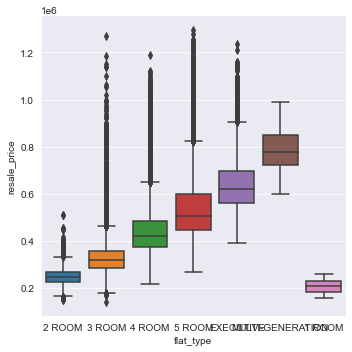

In [405]:

ax = sns.catplot(x='flat_type',y='resale_price',data = data,kind ='box')

### Creating the distance from lat and lon

Latitude and longitude of central area is about 1.300556, 103.821667 (source:wiki), using this info we can calculate the distance to town

In [41]:
lat = 1.300556
lon = 103.821667
# find distance to town

data['distance'] = np.sqrt((data['Latitude']-lat)**2 + (data['Longitude'] - lon)**2)

In [42]:
#Drop lease_commence_dt

data_final = data.drop(columns=['lease_commence_dt','month','resale_price','Latitude','Longitude'],axis=1)

In [43]:
data_final.head()

,town,flat_type,floor_area_sqm,flat_model,Storey,remaining_lease_year,distance
0,ANG MO KIO,2 ROOM,45.0,Improved,8.0,72.836561,0.075600
1,ANG MO KIO,2 ROOM,44.0,Improved,3.0,66.835068,0.077830
2,ANG MO KIO,3 ROOM,68.0,New Generation,8.0,66.835068,0.080755
3,ANG MO KIO,3 ROOM,67.0,New Generation,3.0,70.835151,0.072044
4,ANG MO KIO,3 ROOM,67.0,New Generation,8.0,66.835068,0.080591


In [398]:
# Create dummies variables and map room sizes to number. The room numbers are found on the hdb website.
# For 5 rooms, there's an additional area catered for a study room, however due to its size, I mapped it to
# the value of 4.5
#
dummies = ['town','flat_model']
data_final = pd.get_dummies(data_final,columns=dummies,drop_first=True)
data_final['flat_cat'] = data_final.flat_type.map({'2 ROOM':2,
                                                   '3 ROOM':3,
                                                   '4 ROOM':4,
                                                   '5 ROOM': 5,
                                                   '1 ROOM':1,
                                                   'EXECUTIVE': 6,
                                                    'MULTI-GENERATION':7})

KeyError: "None of [Index(['town', 'flat_model'], dtype='object')] are in the [columns]"

In [45]:
# Create a variable "is_executive"

data_final['Is_executive'] = data_final.flat_type.map({'EXECUTIVE': 1})

# Replace nan with 0
data_final[['Is_executive','flat_cat']] = data_final[['Is_executive','flat_cat']].replace(np.nan,0)

data_final = data_final.drop(columns='flat_type') # Drop 'flat_type'
data_final.head(5)

,floor_area_sqm,Storey,remaining_lease_year,distance,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,...,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2,flat_cat,Is_executive
0,45.0,8.0,72.836561,0.075600,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.0,0.0
1,44.0,3.0,66.835068,0.077830,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.0,0.0
2,68.0,8.0,66.835068,0.080755,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.0,0.0
3,67.0,3.0,70.835151,0.072044,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.0,0.0
4,67.0,8.0,66.835068,0.080591,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.0,0.0


In [46]:
# Create X and y variables
X= data_final
y = data['resale_price']

In [47]:
X.head()

,floor_area_sqm,Storey,remaining_lease_year,distance,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,...,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2,flat_cat,Is_executive
0,45.0,8.0,72.836561,0.075600,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.0,0.0
1,44.0,3.0,66.835068,0.077830,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.0,0.0
2,68.0,8.0,66.835068,0.080755,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.0,0.0
3,67.0,3.0,70.835151,0.072044,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.0,0.0
4,67.0,8.0,66.835068,0.080591,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.0,0.0


## Feature importances using ExtraTreesRegressor

In [54]:
from sklearn.ensemble import ExtraTreesRegressor

sel=ExtraTreesRegressor(n_estimators=50)

sel.fit(X,y)

ExtraTreesRegressor(n_estimators=50)

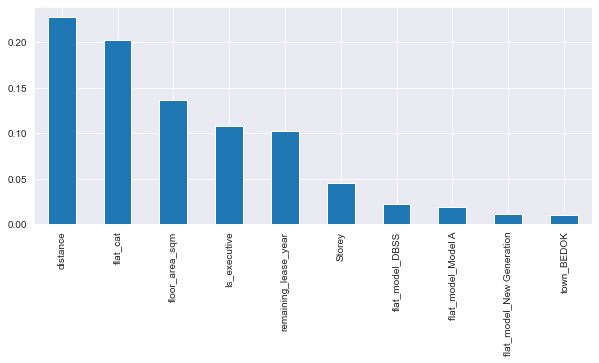

In [55]:
plt.figure(figsize = (10,4))
feat_impt = pd.Series(sel.feature_importances_, index=X.columns)
feat_impt.nlargest(10).plot(kind='bar')
plt.show()

We can observe that distance has the highest importance, which seems logical as houses get more expensive the nearer to town.

## Features selection

In [58]:
# take the top 6 important variables

top6 = list(feat_impt.sort_values(ascending=False).head(6).index)
X1 = data_final[top6]
# we will be using the same y from above
print(X1.shape, y.shape)

(196957, 6) (196957,)


In [59]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X1,y,test_size=0.2)

# Model building

## Random Forest Regressor

In [177]:
from sklearn.ensemble import RandomForestRegressor
rtree=RandomForestRegressor(n_estimators=200,random_state=42)

In [178]:
rtree.fit(X_train,y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [203]:
y_pred_rf = rtree.predict(X_test)
y_pred_rf[:5]

array([539818.02, 480330.34, 434129.44, 547666.5 , 441081.4 ])

### Get metrics

In [343]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
def print_metrics(actual:pd.DataFrame,pred:pd.DataFrame,model_name:str) -> dict:
    mae = mean_absolute_error(actual,pred)
    rmse = np.sqrt(mean_squared_error(actual,pred))
    rs = r2_score(actual,pred)
    print(f"Scores for {model_name.upper()}\n"
          f"Mean absolute error: {mae}\n"
          f"RMSE: {rmse}\n"
          f"R score: {rs}\n")
    return {"Model": model_name.upper(),"MAE": mae, "RMSE": rmse, "R score": rs}

In [344]:
print_metrics(y_test,y_pred_rf,"Random Forest")

Scores for RANDOM FOREST
Mean absolute error: 24718.733830375437
RMSE: 35133.708017160425
R score: 0.9419136784374361



{'Model': 'RANDOM FOREST',
 'MAE': 24718.733830375437,
 'RMSE': 35133.708017160425,
 'R score': 0.9419136784374361}

In [183]:
# Overfit check

print(rtree.score(X_train,y_train))
print(rtree.score(X_test,y_test))

0.9918259487764448
0.9419136784374361


## Hyper-Parameter tuning with XGBoost and HalvingGridSearchCV

In [69]:
#Using halving grid
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
params = {
        'colsample_bytree': [0.5, 0.7,0.9],
        'max_depth': [7,9,11],
        'n_estimators' : [300, 400, 500, 600],
        'subsample' : [0.7,0.8,0.9],
        'objective': ['reg:squarederror']
    
        }

In [321]:
from xgboost import XGBRegressor
xgbooster = XGBRegressor()
gridxg = HalvingGridSearchCV(
                    estimator=xgbooster,
                    param_grid=params,
                    cv=3,
                    n_jobs=6,
                    verbose=1,
                    min_resources='exhaust',
    error_score ='raise'
)
gridxg.fit(X_train,y_train)

gridxg.best_params_

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 1945
max_resources_: 157565
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 108
n_resources: 1945
Fitting 3 folds for each of 108 candidates, totalling 324 fits
----------
iter: 1
n_candidates: 36
n_resources: 5835
Fitting 3 folds for each of 36 candidates, totalling 108 fits
----------
iter: 2
n_candidates: 12
n_resources: 17505
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 3
n_candidates: 4
n_resources: 52515
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 4
n_candidates: 2
n_resources: 157545
Fitting 3 folds for each of 2 candidates, totalling 6 fits


{'colsample_bytree': 0.9,
 'max_depth': 9,
 'n_estimators': 400,
 'objective': 'reg:squarederror',
 'subsample': 0.9}

In [322]:
xgb_model = XGBRegressor(
                tree_method='gpu_hist',
                gpu_id=0,
                objective='reg:squarederror',
                colsample_bytree=0.9,
                learning_rate=0.1,
                max_depth=9,
                n_estimators=600,
                subsample=0.9
                )
%time xgb_model.fit(X_train,y_train,early_stopping_rounds=5,eval_set=[(X_test,y_test)],verbose=False)

CPU times: total: 19.5 s
Wall time: 18.3 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=600, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [323]:
y_pred_xgb = xgb_model.predict(X_test) # Fit model


In [324]:
#Overfit check

print(xgb_model.score(X_train,y_train))

print(xgb_model.score(X_test,y_test))

0.9636251856179975
0.9364102475640359


# Let's try out DNN

In [217]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))

    return model

In [218]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))
print(normalizer.mean.numpy())
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

[[1.0197416e-01 3.5228634e+00 9.7275284e+01 7.9097733e-02 7.4543716e+01
  8.3223572e+00]]
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_11 (Normalizat (None, 6)                 13        
_________________________________________________________________
dense_36 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_37 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 65        
Total params: 8,846
Trainable params: 8,833
Non-trainable params: 13
_________________________________________________________________


In [219]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor= 'val_loss',patience=5)

In [220]:
%%time
history = dnn_model.fit(
    X_train,
    y_train,
    validation_split=0.25,
    verbose=1,
    epochs=100,
    batch_size = 128,
    callbacks=[early_stopping])

Epoch 1/100
924/924 [==============================] - 3s 3ms/step - loss: 103555276800.0000 - val_loss: 8318208000.0000
Epoch 2/100
924/924 [==============================] - 3s 3ms/step - loss: 6630790656.0000 - val_loss: 5527578112.0000
Epoch 3/100
924/924 [==============================] - 3s 3ms/step - loss: 5097924096.0000 - val_loss: 4818625024.0000
Epoch 4/100
924/924 [==============================] - 3s 3ms/step - loss: 4691069952.0000 - val_loss: 4587819520.0000
Epoch 5/100
924/924 [==============================] - 3s 3ms/step - loss: 4521020928.0000 - val_loss: 4466924544.0000
Epoch 6/100
924/924 [==============================] - 3s 3ms/step - loss: 4424088064.0000 - val_loss: 4393664000.0000
Epoch 7/100
924/924 [==============================] - 3s 3ms/step - loss: 4359018496.0000 - val_loss: 4340838912.0000
Epoch 8/100
924/924 [==============================] - 3s 3ms/step - loss: 4309280768.0000 - val_loss: 4297420800.0000
Epoch 9/100
924/924 [=========================

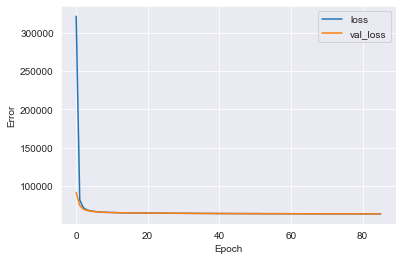

In [221]:
def plot_loss(history):
    plt.plot(np.sqrt(history.history['loss']), label='loss')
    plt.plot(np.sqrt(history.history['val_loss']), label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
plot_loss(history)

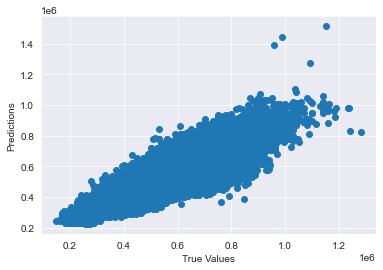

In [222]:
y_pred_dnn = dnn_model.predict(X_test).flatten()

plt.scatter(y_test, y_pred_dnn)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [223]:
y_pred_dnn =  y_pred_dnn.round(0)
y_pred_dnn

array([544209., 449626., 399818., ..., 404328., 781929., 551347.],
      dtype=float32)

# Model evaluation

In [345]:
# XGB
print_metrics(y_test,y_pred_xgb,"XGB")
print_metrics(y_test,y_pred_rf,"RF")
print_metrics(y_test,y_pred_dnn,"DNN")

Scores for XGB
Mean absolute error: 26706.323901601212
RMSE: 36760.43292982519
R score: 0.9364102475640359

Scores for RF
Mean absolute error: 24718.733830375437
RMSE: 35133.708017160425
R score: 0.9419136784374361

Scores for DNN
Mean absolute error: 47779.15612840171
RMSE: 63156.035940917696
R score: 0.8123037371074675



{'Model': 'DNN',
 'MAE': 47779.15612840171,
 'RMSE': 63156.035940917696,
 'R score': 0.8123037371074675}

<AxesSubplot:title={'center':'DNN'}, xlabel='resale_price', ylabel='Count'>

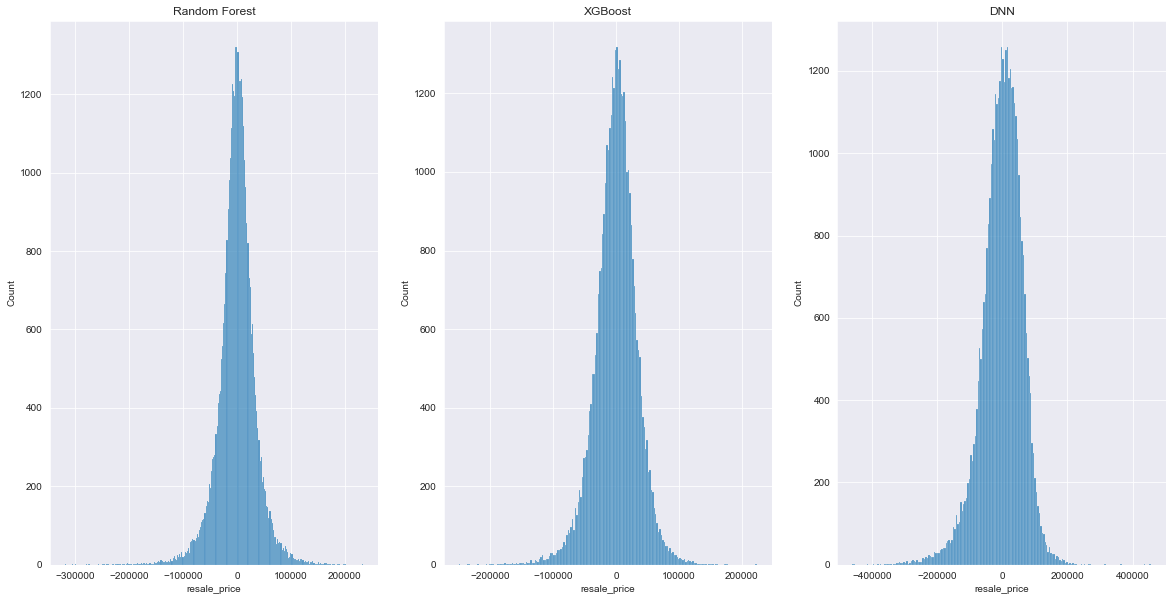

In [289]:
# Print the histplot of XGBoost and Random forest pred values for comparison
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (20,10))
ax1.set_title('Random Forest')
ax2.set_title('XGBoost')
ax3.set_title('DNN')
sns.histplot(y_pred_rf-y_test,ax=ax1,)
sns.histplot(y_pred_xgb-y_test,ax=ax2)
sns.histplot(y_pred_dnn-y_test, ax= ax3)

In [243]:
# Make into a dataframe
d = {"Random Forest": y_pred_rf, "XGBRegressor": y_pred_xgb, "DNN":y_pred_dnn, "Actual":y_test}
df_y = pd.DataFrame.from_dict(d)

In [244]:
df_y.head()

,Random Forest,XGBRegressor,DNN,Actual
52432,539818.02,555608.25000,544209.0,622000.0
194803,480330.34,478001.84375,449626.0,485000.0
3552,434129.44,429585.50000,399818.0,450000.0
151953,547666.50,547036.87500,476312.0,528000.0
73574,441081.40,432384.75000,451219.0,450000.0


In [249]:
# This finds the absolute biggest % difference between the models

max_diff_rt = ((df_y['Actual']-df_y['Random Forest'])/(df_y['Actual'])).abs().max()
max_diff_xgb =((df_y['Actual']-df_y['XGBRegressor'])/(df_y['Actual'])).abs().max()
max_diff_dnn =((df_y['Actual']-df_y['DNN'])/(df_y['Actual'])).abs().max()

print("Max difference in price for random forest is : ",max_diff_rt
     ,"\nMax difference in price for XGB is : " , max_diff_xgb
      ,"\nMax difference in price for DNN is : " , max_diff_dnn)

Max difference in price for random forest is :  0.7984703111111111 
Max difference in price for XGB is :  0.8919409722222222 
Max difference in price for DNN is :  0.8083714285714285


In [246]:
# This finds and prints the row with the biggest % difference

rt_diff_index = ((df_y['Actual']-df_y['Random Forest'])/(df_y['Actual'])).abs().idxmax()
xgb_diff_index =((df_y['Actual']-df_y['XGBRegressor'])/(df_y['Actual'])).abs().idxmax()
dnn_diff_index = ((df_y['Actual']-df_y['DNN'])/(df_y['Actual'])).abs().idxmax()
print("Row with greatest difference:")
print(df_y.loc[[rt_diff_index]])
print(df_y.loc[[xgb_diff_index]])
print(df_y.loc[[dnn_diff_index]])


Row with greatest difference:
        Random Forest  XGBRegressor       DNN    Actual
184691      404655.82   347149.0625  317151.0  225000.0
        Random Forest  XGBRegressor       DNN    Actual
145412      282401.04    340549.375  309729.0  180000.0
        Random Forest  XGBRegressor       DNN    Actual
159479       366487.2   354051.3125  506344.0  280000.0


## Experimentation and learning keras-tuner

In [251]:
import keras_tuner as kt

In [286]:
def model_builder(hp,norm=normalizer):
    model = keras.Sequential()

    model.add(norm)

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(1))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss="mean_squared_error",
                  metrics = "mean_squared_error")

    return model

In [287]:
hyperband = kt.Hyperband(model_builder,
                     objective= "mean_squared_error",
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt1')
early_stopping = EarlyStopping(monitor= 'mean_squared_error',patience=5)

INFO:tensorflow:Reloading Oracle from existing project my_dir\intro_to_kt1\oracle.json


In [288]:
hyperband.search(X_train,
             y_train,
             epochs = 50,
             validation_split=0.2,
             callbacks=[early_stopping])

Trial 30 Complete [00h 01m 41s]
mean_squared_error: 4296901632.0

Best mean_squared_error So Far: 4285548288.0
Total elapsed time: 00h 20m 25s
INFO:tensorflow:Oracle triggered exit


In [290]:
# Get the optimal hyper parameters
best_hps=hyperband.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 320 and the optimal learning rate for the optimizer
is 0.01.



## Build model with parameters

In [292]:
hyperband_model = hyperband.hypermodel.build(best_hps)
history_hyperband = hyperband_model.fit(X_train,
                                        y_train,
                                        epochs = 100,
                                        validation_split = 0.2,
                                        batch_size= 128)



Epoch 1/100
985/985 [==============================] - 3s 3ms/step - loss: 189663346688.0000 - mean_squared_error: 189663346688.0000 - val_loss: 127103533056.0000 - val_mean_squared_error: 127103533056.0000
Epoch 2/100
985/985 [==============================] - 2s 2ms/step - loss: 68298174464.0000 - mean_squared_error: 68298174464.0000 - val_loss: 27309516800.0000 - val_mean_squared_error: 27309516800.0000
Epoch 3/100
985/985 [==============================] - 2s 2ms/step - loss: 15260404736.0000 - mean_squared_error: 15260404736.0000 - val_loss: 9714469888.0000 - val_mean_squared_error: 9714469888.0000
Epoch 4/100
985/985 [==============================] - 2s 2ms/step - loss: 8478457856.0000 - mean_squared_error: 8478457856.0000 - val_loss: 7503640064.0000 - val_mean_squared_error: 7503640064.0000
Epoch 5/100
985/985 [==============================] - 2s 2ms/step - loss: 6856179200.0000 - mean_squared_error: 6856179200.0000 - val_loss: 6262088704.0000 - val_mean_squared_error: 6262088

KeyError: 'val_accuracy'

In [298]:
val_loss_per_epoch = history_hyperband.history['val_mean_squared_error']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 100


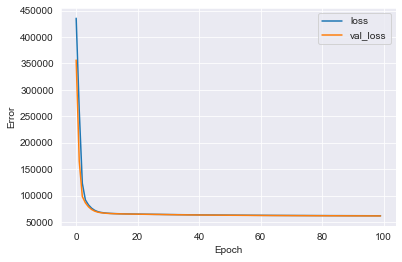

In [296]:
plot_loss(history_hyperband)

In [315]:
y_pred_hyperband = hyperband_model.predict(X_test)

In [316]:
print_metrics(y_test,y_pred_hyperband)

Mean absolute error: 46817.23286590551
RMSE: 61936.14429648954
R score: 0.8194846112971954


# Conclusion + Summary of models

It doesn't seem that NN is worth the effort and computing power to train a NN, perhaps my knowledge of NN is not deep enough

## Comparison of scores

In [347]:
list_of_predictions = [y_pred_rf,y_pred_xgb,y_pred_dnn,y_pred_hyperband]
name = ['rf','xgb','dnn','hyperband']

In [349]:
metrics_combined = []
for i in range(len(name)):
    metrics_combined.append(print_metrics(y_test,list_of_predictions[i],name[i]))

Scores for RF
Mean absolute error: 24718.733830375437
RMSE: 35133.708017160425
R score: 0.9419136784374361

Scores for XGB
Mean absolute error: 26706.323901601212
RMSE: 36760.43292982519
R score: 0.9364102475640359

Scores for DNN
Mean absolute error: 47779.15612840171
RMSE: 63156.035940917696
R score: 0.8123037371074675

Scores for HYPERBAND
Mean absolute error: 46817.23286590551
RMSE: 61936.14429648954
R score: 0.8194846112971954



[{'Model': 'RF',
  'MAE': 24718.733830375437,
  'RMSE': 35133.708017160425,
  'R score': 0.9419136784374361},
 {'Model': 'XGB',
  'MAE': 26706.323901601212,
  'RMSE': 36760.43292982519,
  'R score': 0.9364102475640359},
 {'Model': 'DNN',
  'MAE': 47779.15612840171,
  'RMSE': 63156.035940917696,
  'R score': 0.8123037371074675},
 {'Model': 'HYPERBAND',
  'MAE': 46817.23286590551,
  'RMSE': 61936.14429648954,
  'R score': 0.8194846112971954}]

In [355]:
Summary = pd.DataFrame(metrics_combined).set_index('Model')

In [357]:
Summary.transpose()

Model,RF,XGB,DNN,HYPERBAND
MAE,24718.733830,26706.323902,47779.156128,46817.232866
RMSE,35133.708017,36760.432930,63156.035941,61936.144296
R score,0.941914,0.936410,0.812304,0.819485


# Deployment example

In [367]:
import requests
def getcoordinates(address):
    address = str(address)
    req = requests.get('https://developers.onemap.sg/commonapi/search?searchVal='+address+'&returnGeom=Y&getAddrDetails=Y&pageNum=1')
    resultsdict = eval(req.text)
    if len(resultsdict['results'])>0:
        return [resultsdict['results'][0]['LATITUDE'], resultsdict['results'][0]['LONGITUDE']]
    else:
        pass

In [368]:
getcoordinates(530697)

['1.37554033809538', '103.887475138873']

In [375]:
max(X_train[X_train['Is_executive'] == 1.0]['flat_cat'])

0.0

In [ ]:
req_inputs = {"Postal": 530699,
            "Lease year": 1998,
              "Storey": 10,
              "Floor_area_sqm": 100,
              "Rooms": 4,
              "Executive": True}

def parse_inputs(inputs:dict):
